# EX1) Classifier comparison

- 데이터 분류기 시각화 비교

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
names = [
    'Nearest Neighbors',
    'Linear SVM',
    'RBF SVM',
    'Gaussian Process',
    'Decision Tree',
    'Random Forest',
    'Neural Net',
    'AdaBoost',
    'Naive Bayes',
    'QDA',
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel='linear', C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42,
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [3]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

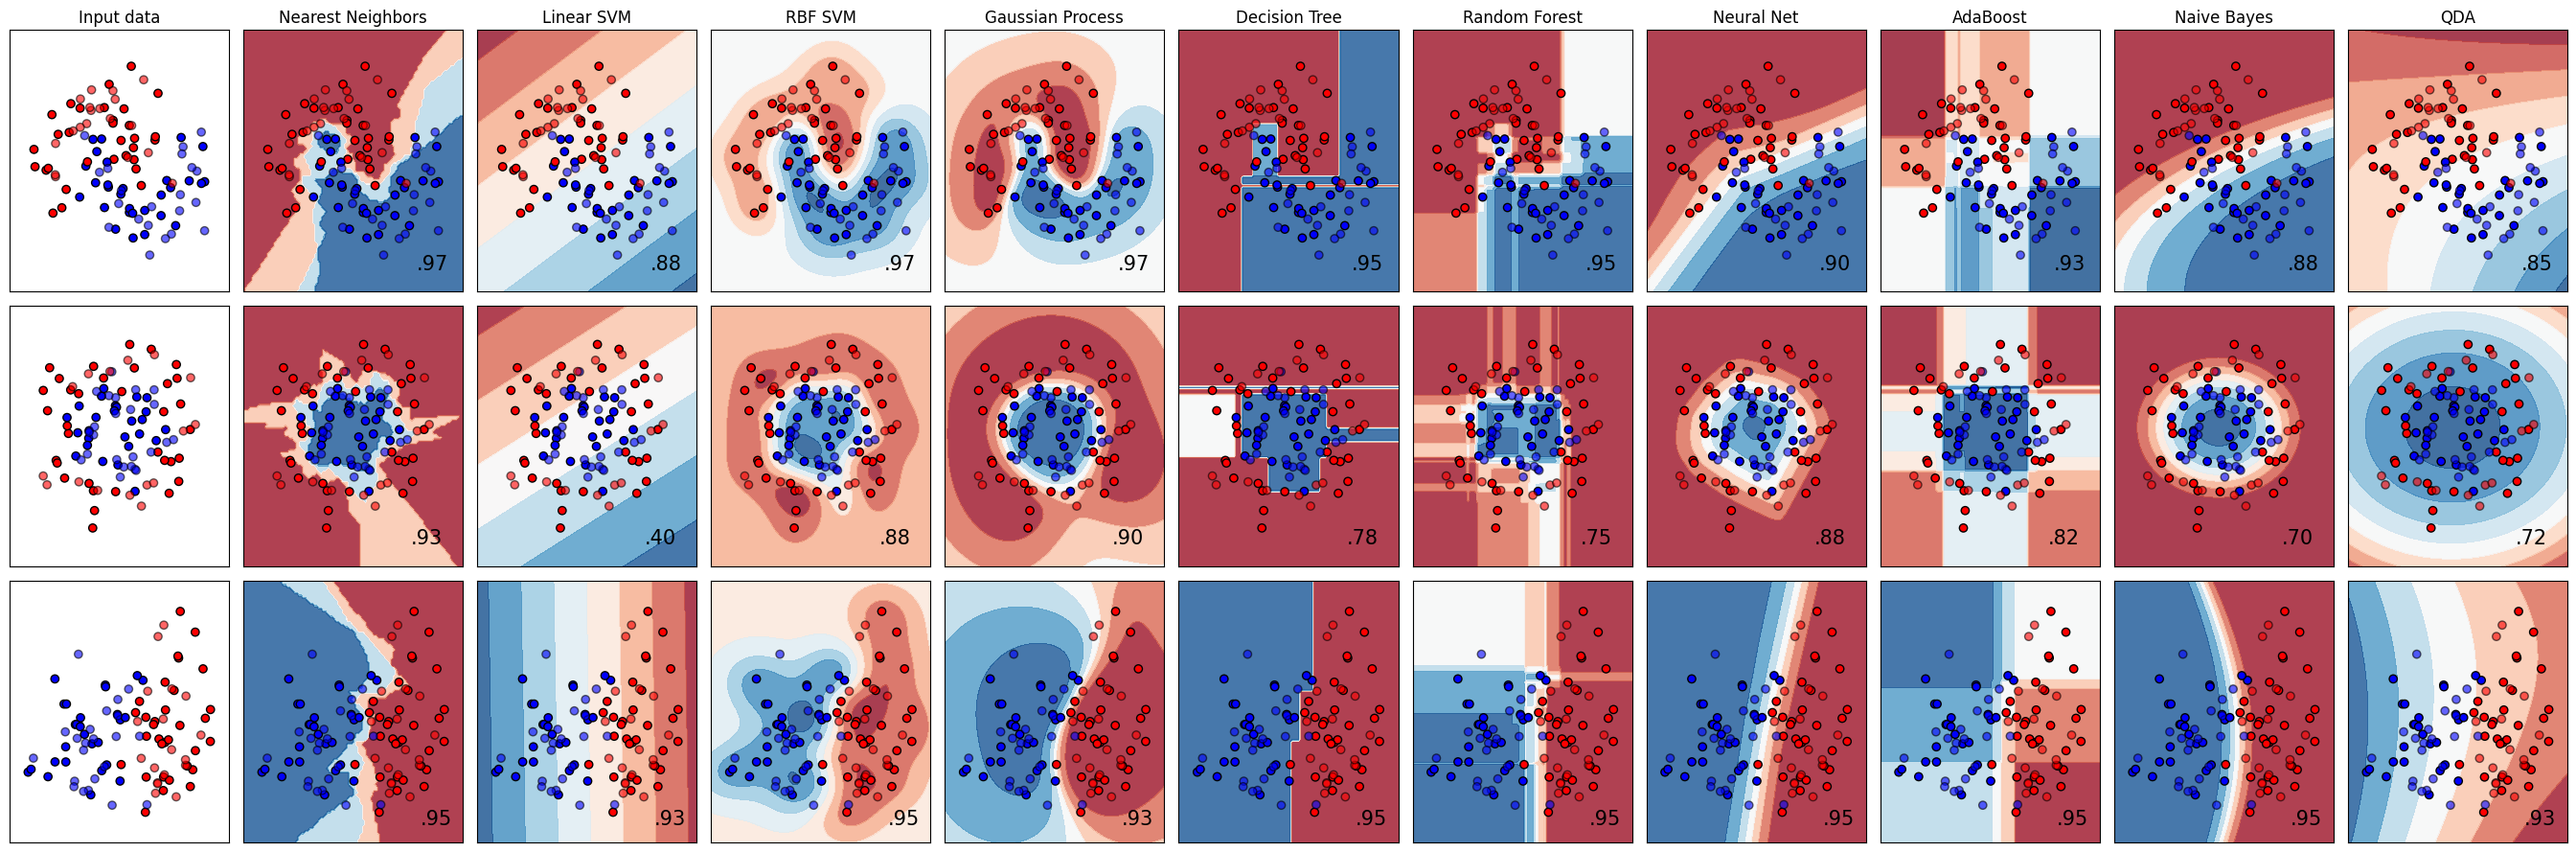

In [4]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title('Input data')
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k'
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k'
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors='k',
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ('%.2f' % score).lstrip('0'),
            size=15,
            horizontalalignment='right',
        )
        i += 1

plt.tight_layout()
plt.show()

# EX2) Linear and Quadratic Discriminant Analysis with covariance ellipsoid

- LDA, QDA

In [5]:
# Colormap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {
        'red': [(0, 1, 1), (1, 0.7, 0.7)],
        'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        'blue': [(0, 0.7, 0.7), (1, 1, 1)]
    }
)

plt.cm.register_cmap(cmap=cmap)

/var/folders/08/nb973_yd7y99l990glgy1mbw0000gn/T/ipykernel_2777/1586600057.py:16: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


In [6]:
# Datasets generation functions

import numpy as np

def dataset_fixed_cov():
    '''공분산이 같은 가우시안 샘플 2개 만들기'''
    n, dim = 300, 2
    np.random.seed(0)

    C = np.array([[0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_cov():
    '''공분산이 다른 가우시안 샘플 2개 만들기'''
    n, dim = 300, 2
    np.random.seed(0)
    
    C = np.array([[0, -1], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [7]:
# plot functions

from scipy import linalg

def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quandratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = y == y_pred # True positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')

    # class 1
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099'
    )

    # class 0 & 1
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap='red_blue_classes', norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors='white')

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        '*',
        color='yellow',
        markersize=15,
        markeredgecolor='grey'
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        '*',
        color='yellow',
        markersize=15,
        markeredgecolor='grey'
    )

    return splot

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi

    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor='black',
        linewidth=2
    )

    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')

def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

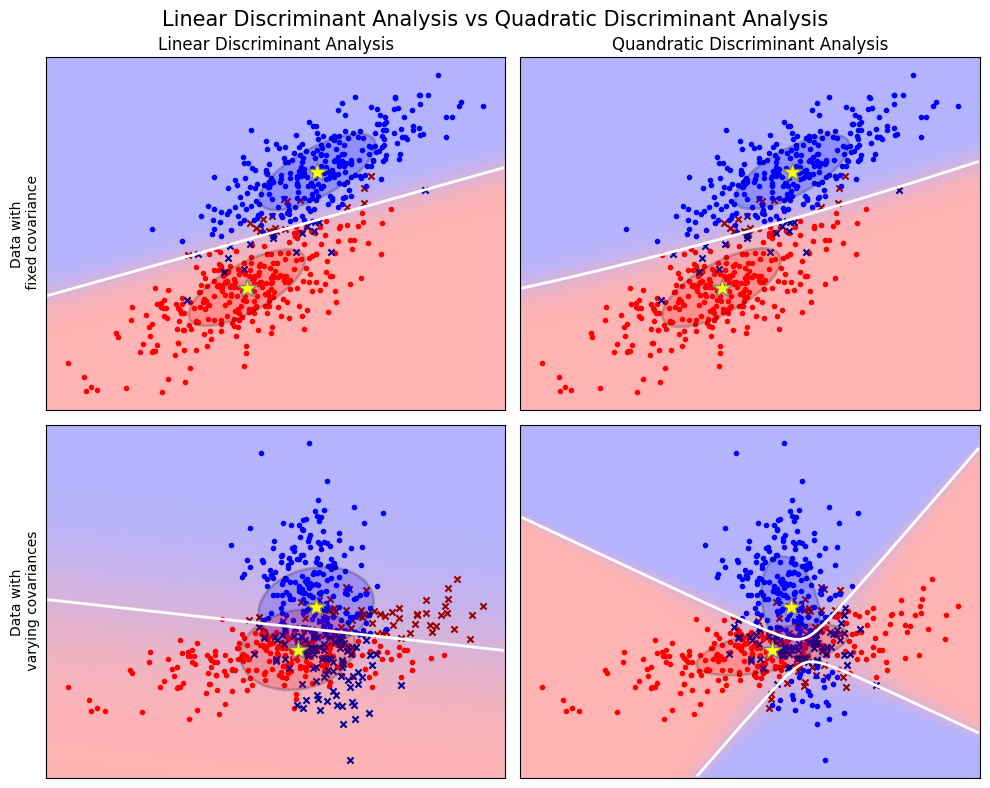

In [8]:
# PLOT

plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle(
    'Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
    y=0.98,
    fontsize=15
)

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2*i+1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2*i+2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# EX3) Normal, Ledoit-Wolf and OAS Linear Discriminant Analysis for claffication
- Ledoit-Wolf, OAS

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.covariance import OAS
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_train = 20
n_test = 200
n_averages = 50
n_features_max = 75
step = 4

def generate_date(n_samples, n_features):
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features-1)])
    
    return X, y

In [10]:
acc_clf1, acc_clf2, acc_clf3 = [], [], []
n_features_range = range(1, n_features_max+1, step)
for n_features in n_features_range:
    score_clf1, score_clf2, score_clf3 = 0, 0, 0
    for _ in range(n_averages):
        X, y = generate_date(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X, y)
        oa = OAS(store_precision=False, assume_centered=False)
        clf3 = LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator=oa).fit(X, y)

        X, y = generate_date(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)
        score_clf3 += clf3.score(X, y)

    acc_clf1.append(score_clf1/n_averages)
    acc_clf2.append(score_clf2/n_averages)
    acc_clf3.append(score_clf3/n_averages)

feature_samples_ratio = np.array(n_features_range) / n_train

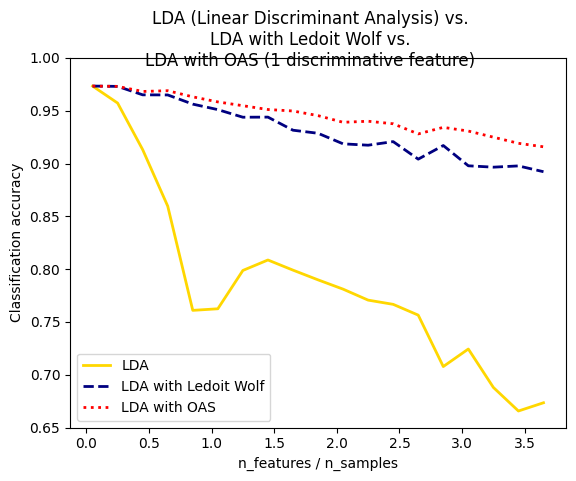

In [11]:
# Plot

plt.plot(
    feature_samples_ratio,
    acc_clf1,
    linewidth=2,
    label='LDA',
    color='gold',
    linestyle='solid'
)
plt.plot(
    feature_samples_ratio,
    acc_clf2,
    linewidth=2,
    label='LDA with Ledoit Wolf',
    color='navy',
    linestyle='dashed'
)
plt.plot(
    feature_samples_ratio,
    acc_clf3,
    linewidth=2,
    label='LDA with OAS',
    color='red',
    linestyle='dotted'
)

plt.xlabel('n_features / n_samples')
plt.ylabel('Classification accuracy')

plt.legend(loc = 'lower left')
plt.ylim((0.65, 1.0))
plt.suptitle(
    'LDA (Linear Discriminant Analysis) vs.'
    + '\n'
    + 'LDA with Ledoit Wolf vs.'
    + '\n'
    + 'LDA with OAS (1 discriminative feature)'
)

plt.show()

# EX4) Plot classification probability
- SVC, L1, L2, One-Vs-Rest, multinomial setting, Gaussian process classification

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [13]:
iris = datasets.load_iris()
X = iris.data[:, 0:2]
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])

classifiers = {
    'L1 logistic': LogisticRegression(
        C=C, penalty='l1', solver='saga', multi_class='multinomial', max_iter=10_000
    ),
    'L2 logistic': LogisticRegression(
        C=C, penalty='l2', solver='saga', multi_class='multinomial', max_iter=10_000
    ),
    'L2 logistic (OvR)': LogisticRegression(
        C=C, penalty='l2', solver='saga', multi_class='ovr', max_iter=10_000
    ),
    'Linear SVC': SVC(
        kernel='linear', C=C, probability=True, random_state=0
    ),
    'GPC': GaussianProcessClassifier(kernel),
}

n_classifiers = len(classifiers)

Accuracy (train) for L1 logistic: 83.3
Accuracy (train) for L2 logistic: 82.7
Accuracy (train) for L2 logistic (OvR): 79.3
Accuracy (train) for Linear SVC: 82.0
Accuracy (train) for GPC: 82.7


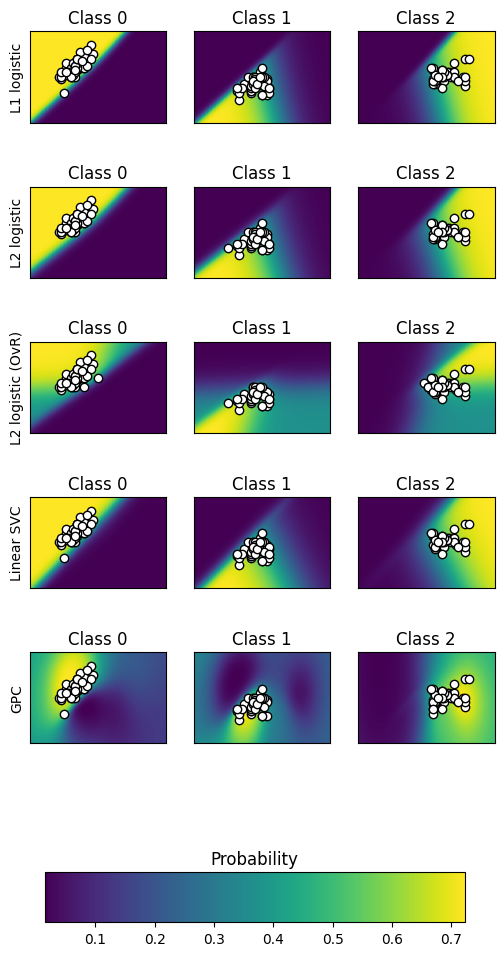

In [14]:
# PLOT

plt.figure(figsize=(3*2, n_classifiers*2))
plt.subplots_adjust(bottom=0.2, top=0.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f'Accuracy (train) for {name}: {accuracy*100:0.1f}')

    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title(f'Class {k:d}')
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(
            probas[:, k].reshape((100, 100)), extent=(3, 9, 1, 5), origin='lower'
        )
        plt.xticks(())
        plt.yticks(())
        idx = y_pred == k
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolors='k')
        
ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title('Probability')
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

# EX5) Recognizing hand-written digits

In [15]:
import matplotlib.pyplot as plt

from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

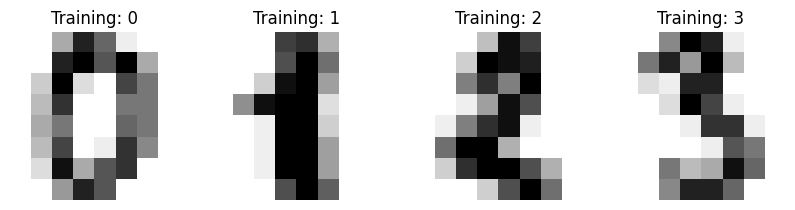

In [16]:
# Digits datasets

digits = datasets.load_digits()

_, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Training: {label}')

In [17]:
# CLASSIFICATION

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

clf = svm.SVC(gamma=0.001)

X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

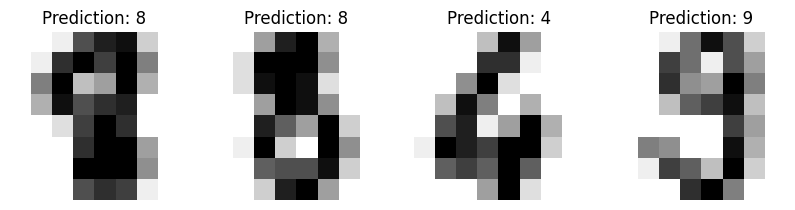

In [18]:
_, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [19]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


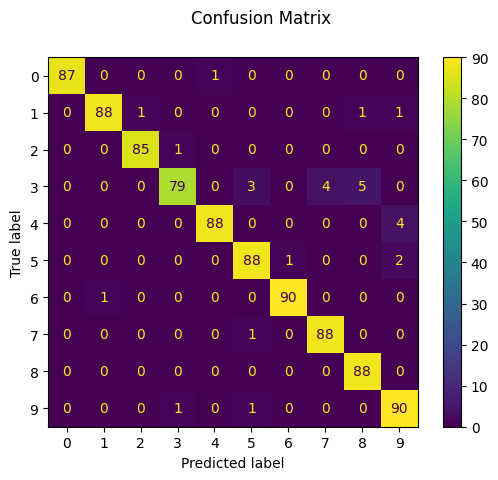

In [20]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion matrix:\n{disp.confusion_matrix}')

plt.show()

In [21]:
y_true, y_pred = [], []
cm = disp.confusion_matrix

for gt in range(len(cm)):
    for pred in range(len(cm)):
        y_true += [gt] * cm[gt][pred]
        y_pred += [pred] * cm[gt][pred]

print(
    'Classification report rebuilt from confusion matrix'
    + '\n'
    + metrics.classification_report(y_true, y_pred)
    + '\n'
)

Classification report rebuilt from confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899


